# TrueLayer - Data Scientist - Take-home test

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import randint
import pickle

%matplotlib inline

# Style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

# Dataset loading
df = pd.read_csv('filtered_df.csv')

## Model training

We are going to take a simple approach to the model training.

Our goal is to train a model that is able to give a probability of a payment being successful. We could use this to, for example, create thresholds where different actions and results could occur based on different probabilities.

The model used will be an XGBoost model, as based on previous experience it has good results with a fairly simple approach to unbalanced datasets (like ours) and can take categorical features directly, so we don't have to worry about encoding.

I will use random search for hyperparameter optimisation, as it provides a faster way, when compared to grid search, to find parameters that, while not absolutely optimal, should be very close.

Finally, after finding and training the optimal model, we will run a series of tests on its performance.

In [2]:
# Checking columns after feature engineering
df.columns

Index(['bank_id', 'currency', 'status', 'api_version', 'customer_id',
       'vertical', 'connectivity_type', 'amount_in_currency', 'country_id',
       'createdat_ts', 'customer_previous_payment_count', 'is_success',
       'customer_success_count', 'is_failure', 'customer_fail_count',
       'fail_rate', 'time_since_first_transaction'],
      dtype='object')

We will drop 5 features now:
- **customer_id** - Using customer_id as part of the model would result in overfitting
- **createdat_ts** - Could result in leakage and overfitting
- **is_failure/is_success** - Related to the target column
- **api_version** - After a first run, we found that API Version dominated the feature importance chart which still resulted in good performance in this dataset but would probably not correlate with good performance in any future transactions, especially as new API version are released. As such, it is preferrable to not use it at this stage.

In [3]:
df = df.drop(['customer_id','createdat_ts','is_failure','is_success','api_version'], axis=1)

In [4]:
# Dropping the target column from X and mapping the values labels 1 and 0, 1 will be uour positive label and will indicate success.
X = df.drop(['status'], axis=1)
y = df['status'].map({'failed': 0, 'executed': 1})

In [5]:
# The dataset is unbalanced
y.value_counts(normalize=True)*100

status
1    89.33111
0    10.66889
Name: proportion, dtype: float64

As the dataset is unbalanced, we have two simple options when using XGBoost and random search: scale_pos_weight as a parameter of the model or sample_weights in the search. After testing both, the difference in performance was not significant, so we went with the latter.

We could also use synthetic sample creation techniques like SMOTE, but at this time, its performance has not been tested.

In [7]:
X.dtypes

bank_id                            category
currency                           category
vertical                           category
connectivity_type                  category
amount_in_currency                  float64
country_id                         category
customer_previous_payment_count       int64
customer_success_count              float64
customer_fail_count                 float64
fail_rate                           float64
time_since_first_transaction        float64
dtype: object

In [8]:
# Changing object features to categorical so that the XGBoost model can use them directly
categorical_features = ['bank_id', 'currency', 'vertical', 'connectivity_type', 'country_id']

for feature in categorical_features:
    X[feature] = X[feature].astype('category')


In [10]:
# We will use a simple train test split, with 20% being test and stratified to make sure the proportions of failed payments match.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)


In [14]:
# Calculating sample weigths to make up for the unbalanced dataset, one of many possible approaches
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [15]:
# XGBoost model with categorical features
model = xgb.XGBClassifier(random_state=12, enable_categorical=True)


For hyperparamenter optimisation, we started with a wider set of parameters and through testing focus on a more limited range which is shown next. 

In [16]:

param_dist = {
    'n_estimators': randint(200, 701),  
    'max_depth': randint(5, 10),      
    'eta': list(np.linspace(0.05, 0.35, 5)),
    'subsample': list(np.linspace(0.5, 0.9, 5)), 
    'colsample_bytree': list(np.linspace(0.5, 0.9, 5)),  
    'gamma': list(np.linspace(0.1, 0.4, 5)), 
    'min_child_weight': randint(1, 11),  
    'scale_pos_weight': [1]    
}

We will be using Stratified K fold for the cross validation of the random search. This allows us to minimise the chance of overfitting.

While usually, splits as high as 5 are recommended, that drastically increases the training time so in an effort to have a good but fast first prototype we decreased it to 2. After some comparisons, this didn't seem to affect performance.

We will also be test 75 different combinations, these number could, once again, be much larger but it would, similarly to the number of folds, increase training time. 75 proved to be a good number to be able to find a high performance model without too much delay in training.

We will also be using ROC AUC as the scoring in order to evaluate and select the best model, this is much more preferable to something like accuracy due to it being a lot more resistant to class imbalance. It also has the advantage of provide a measure of performance across all possible probability thresholds which, since we do not have a default one yet, is ideal. 

Another appropriate metrics that we have used during development was F1 score and it will calculated as part of the model evaluation.

In [18]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=12)
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=75, 
    cv=cv, 
    verbose=3, 
    n_jobs=1, 
    return_train_score=True,
    random_state=12,
    scoring='roc_auc'
    )

In [19]:
# Random search will awlways output train and test score as way to make sure we are not consistenyl overfitting
random_search.fit(X_train, y_train, sample_weight=sample_weights, verbose=3)


Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV 1/2] END colsample_bytree=0.8, eta=0.27499999999999997, gamma=0.17500000000000002, max_depth=7, min_child_weight=4, n_estimators=651, scale_pos_weight=1, subsample=0.9;, score=(train=0.961, test=0.786) total time=   7.5s
[CV 2/2] END colsample_bytree=0.8, eta=0.27499999999999997, gamma=0.17500000000000002, max_depth=7, min_child_weight=4, n_estimators=651, scale_pos_weight=1, subsample=0.9;, score=(train=0.960, test=0.789) total time=   7.7s
[CV 1/2] END colsample_bytree=0.5, eta=0.125, gamma=0.4, max_depth=6, min_child_weight=3, n_estimators=659, scale_pos_weight=1, subsample=0.7;, score=(train=0.890, test=0.803) total time=   6.0s
[CV 2/2] END colsample_bytree=0.5, eta=0.125, gamma=0.4, max_depth=6, min_child_weight=3, n_estimators=659, scale_pos_weight=1, subsample=0.7;, score=(train=0.889, test=0.805) total time=   6.1s
[CV 1/2] END colsample_bytree=0.5, eta=0.05, gamma=0.4, max_depth=7, min_child_weight=10, n_estima

RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=12, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importanc...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018E9AB2D760>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018E9AB2F350>,
                                        'scale_pos_weight': [1],
                                        'subsample': [np.float64(0.5),
                                                      np.float64(0.6),
                                                      np.float64(0.7),
                                                      np.float64(0.8),
                                                      np.float64(0.9)]},
                   random_state=12, return_train_score=True, scoring='roc_auc',
                   verbose=3)

Best parameters: {'colsample_bytree': np.float64(0.7), 'eta': np.float64(0.05), 'gamma': np.float64(0.25), 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 546, 'scale_pos_weight': 1, 'subsample': np.float64(0.9)}
Best cross-validation score: 0.8136387987920292

Test set performance:
F1 Score: 0.711
ROC AUC Score: 0.815

Confusion Matrix:
[[ 8332   688]
 [33496 42027]]

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.92      0.33      9020
           1       0.98      0.56      0.71     75523

    accuracy                           0.60     84543
   macro avg       0.59      0.74      0.52     84543
weighted avg       0.90      0.60      0.67     84543


Feature Importance:
fail_rate: 0.3580
customer_fail_count: 0.1782
connectivity_type: 0.1100
customer_success_count: 0.0788
bank_id: 0.0515
vertical: 0.0511
customer_previous_payment_count: 0.0386
currency: 0.0369
country_id: 0.0368
time_since_first_transaction: 0.0358
a

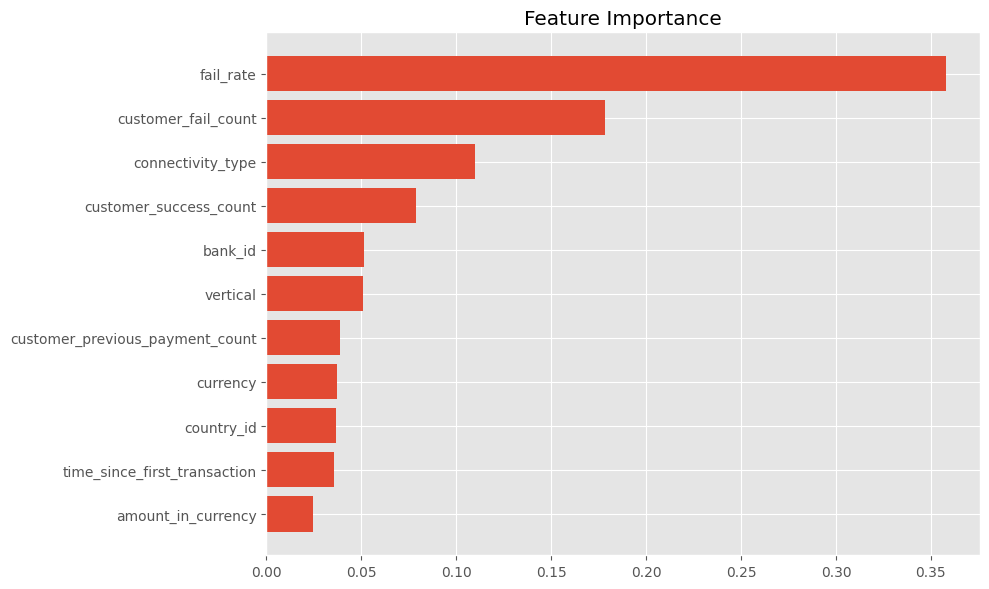

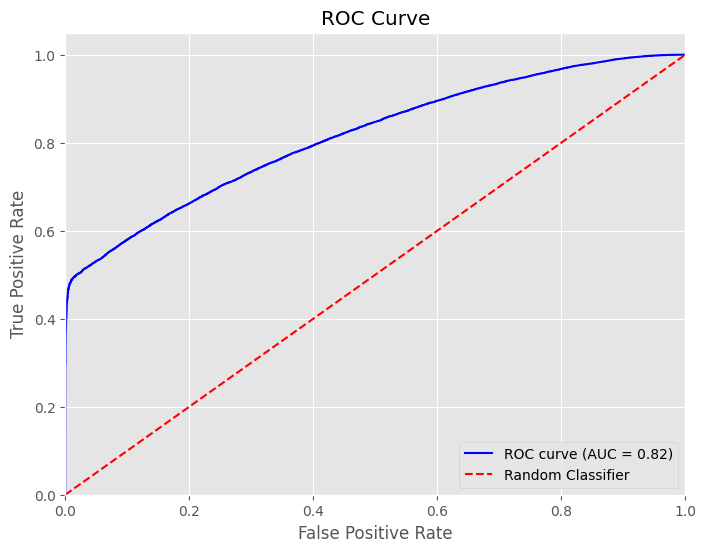

In [26]:
# Get best model
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

# Model evaluation
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)
print("\nTest set performance:")
print("F1 Score:", round(f1_score(y_test, y_pred), 3))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_pred_proba), 3))

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = best_model.feature_importances_
feature_names = X.columns
print("\nFeature Importance:")
for importance, name in sorted(zip(feature_importance, feature_names), reverse=True):
    print(f"{name}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



In [25]:
# Examples: Get success probabilities for a few samples
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_data = X_test.iloc[sample_indices]
sample_probabilities = best_model.predict_proba(sample_data)[:, 1]

print("\nExample failure probabilities:")
for i, (index, prob) in enumerate(zip(sample_indices, sample_probabilities)):
    print(f"Sample {i+1}: {prob*100:.1f}")


Example failure probabilities:
Sample 1: 25.9
Sample 2: 99.9
Sample 3: 38.7
Sample 4: 100.0
Sample 5: 39.1


As we can see, we have been able to train a model that has an acceptable performance and is able to provide success probabilities for each payment.
5
When looking at the feature importance, it validates our approach that 3 out of the top 5 features have been created during feature engineering, and it reinforces the importance of that step to the overall performance of the model.

When considering practical applications of the model, one straightforward approach would be to establish a probability threshold. This threshold would serve as a decision point, determining distinct courses of action based on whether we predict a payment is likely to succeed or fail.

In [32]:
# Saving Model
with open('truelayer_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)